In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

In [2]:
list_of_years = ['1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

In [3]:
def retrieve_and_process_data(year):

    url = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{year}.txt"
    
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        lines = content.splitlines()

        #group can be key, value is area
        # { 1: 54ft**2, 2:  }
        group_area_dict = defaultdict(list)

        for line in lines:
            # print(line, len(line))
            if line.startswith('g'):
                columns = line.split()
                # print(columns)
                
                # Extract the group number (it's in the 7th position after removing whitespaces)
                group_number = columns[7]
                corrected_ws_area = columns[11]
                
                try:
                    int_conversion_of_group_number = int(group_number)
                    float_conversion_of_area = float(corrected_ws_area)
                except ValueError:
                    continue

                # Construct the date from the year, month, and day in the line
                date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                date_obj = datetime.strptime(date_str, '%Y-%m-%d')

                # Append the date to the list for this group number

                # a group can appear on different dates, how to solve this?
                group_area_dict[group_number].append((date_obj, corrected_ws_area))
                
        last_two_months_groups = {group: dates for group, dates in group_area_dict.items() if any(date for date, _ in dates if date.month >= 11)}
        
        # Load data from the next year to check for overlaps
        next_year = str(int(year) + 1)
        
        url_next_year = f"http://fenyi.solarobs.epss.hun-ren.hu/ftp/pub/DPD/data/DPD{next_year}.txt"
        response_next_year = requests.get(url_next_year)
        
        if response_next_year.status_code == 200:
            content_next_year = response_next_year.text
            lines_next_year = content_next_year.splitlines()

            for line in lines_next_year:
                if line.startswith('g'):
                    columns = line.split()
                    group_number = columns[7]
                    corrected_ws_area = columns[11]
                    
                    try:
                        int_conversion_of_group_number = int(group_number)
                        float_conversion_of_area = float(corrected_ws_area)
                    except ValueError:
                        continue

                    date_str = f"{columns[1]}-{columns[2]}-{columns[3]}"
                    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
                    
                    # Only consider dates in January and February of the next year
                    if date_obj.month <= 2 and group_number in last_two_months_groups:
                        group_area_dict[group_number].append((date_obj,corrected_ws_area))
                        
        return group_area_dict
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return 0

def calculate_avg_area(group_area_dict):
    group_count = 0
    total_area = 0
    
    for group, entries in group_area_dict.items():
        try:
            areas = [float(area) for _, area in entries]
        except ValueError:
            continue
        
        # Average area for this group (if a group has multiple observations)
        avg_group_area = max(areas) #/ len(areas)
        if avg_group_area > 1000:
            avg_group_area = 150
        total_area += avg_group_area
        group_count += 1

    if group_count == 0:
        return 0
    return total_area / group_count

In [4]:
list_of_years = [1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [22]:
import concurrent.futures

def process_year(year):
    group_area_dict = retrieve_and_process_data(year)
    if group_area_dict is not None:
        avg_area = calculate_avg_area(group_area_dict)
        return year, avg_area
    else:
        return None

area_list = []

with concurrent.futures.ThreadPoolExecutor(max_workers=14) as executor:
    # Submit each year's processing to the thread pool.
    results = list(executor.map(process_year, list_of_years))

for year, avg_area in results:
    if avg_area is not None:
        area_list.append(avg_area)
        print(f"Average corrected WS whole spot area for sunspot groups in {year}: {avg_area:.2f} millionths")
    else:
        print(f"Processing failed for year {year}")

Average corrected WS whole spot area for sunspot groups in 1974: 121.61 millionths
Average corrected WS whole spot area for sunspot groups in 1975: 83.60 millionths
Average corrected WS whole spot area for sunspot groups in 1976: 116.26 millionths
Average corrected WS whole spot area for sunspot groups in 1977: 99.15 millionths
Average corrected WS whole spot area for sunspot groups in 1978: 126.71 millionths
Average corrected WS whole spot area for sunspot groups in 1979: 143.93 millionths
Average corrected WS whole spot area for sunspot groups in 1980: 137.77 millionths
Average corrected WS whole spot area for sunspot groups in 1981: 128.62 millionths
Average corrected WS whole spot area for sunspot groups in 1982: 150.62 millionths
Average corrected WS whole spot area for sunspot groups in 1983: 122.99 millionths
Average corrected WS whole spot area for sunspot groups in 1984: 116.09 millionths
Average corrected WS whole spot area for sunspot groups in 1985: 107.74 millionths
Averag

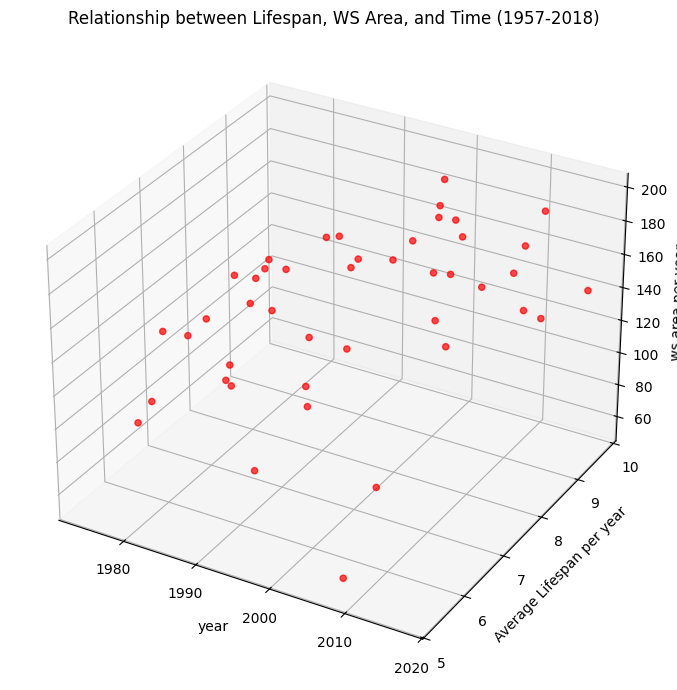

In [6]:
years = np.array(list_of_years)  # Z-axis: Time
ws_area_per_year = np.array(area_list)  # X-axis: WS Area
avg_lifespan_year = np.array([6.92, 6.15, 7.17, 6.16, 7.28, 7.79, 8.35, 7.82, 8.11, 8.0,
                               6.82, 6.68, 7.12, 6.23, 7.49, 8.29, 8.43, 8.54, 8.54, 7.16,
                               6.9, 6.76, 5.35, 7.36, 8.31, 8.62, 9.23, 8.93, 8.71, 8.4,
                               8.76, 8.75, 8.26, 7.69, 5.3, 5.9, 7.39, 8.09, 9.02, 8.52,
                               9.12, 8.4, 8.67, 9.75])  # Y-axis: Average Lifespan


# print(len(ws_area_per_year),len(avg_lifespan_year), len(years))
# Convert to numpy arrays with explicit data type
years = np.array(years, dtype=np.float64)
ws_area_per_year = np.array(area_list, dtype=np.float64)
avg_lifespan_year = np.array(avg_lifespan_year, dtype=np.float64)

# Create a new figure for the 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(years, avg_lifespan_year, ws_area_per_year, c='red', alpha=0.7)

# Set labels and title
ax.set_xlabel('year')
ax.set_ylabel('Average Lifespan per year')
ax.set_zlabel('ws area per year')
ax.set_title('Relationship between Lifespan, WS Area, and Time (1957-2018)')

plt.tight_layout()
plt.show()

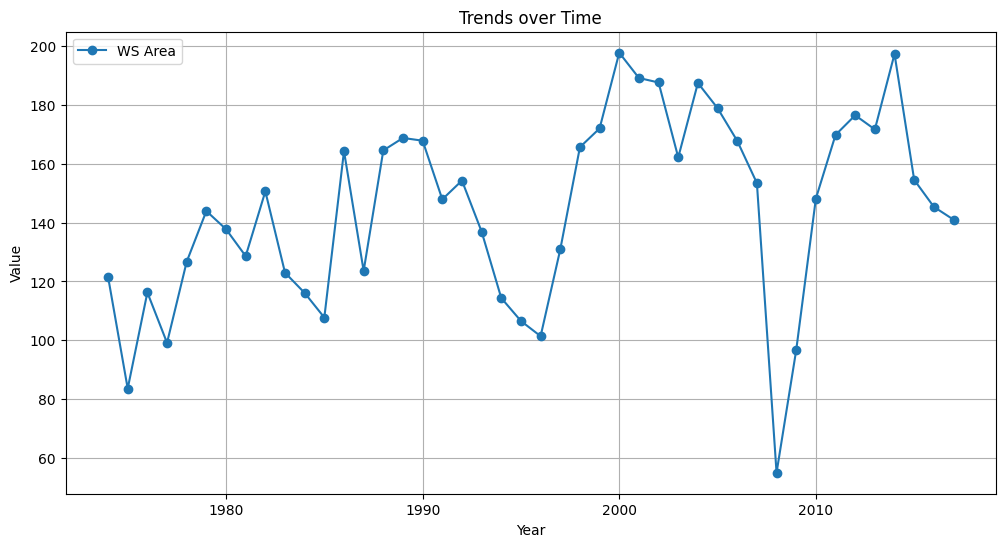

In [7]:
years = np.array(list_of_years)  # converted integer list of years
ws_area_per_year = np.array(area_list, dtype=np.float64)
avg_lifespan_year = np.array([6.92, 6.15, 7.17, 6.16, 7.28, 7.79, 8.35, 7.82, 8.11, 8.0,
                              6.82, 6.68, 7.12, 6.23, 7.49, 8.29, 8.43, 8.54, 8.54, 7.16,
                              6.9, 6.76, 5.35, 7.36, 8.31, 8.62, 9.23, 8.93, 8.71, 8.4,
                              8.76, 8.75, 8.26, 7.69, 5.3, 5.9, 7.39, 8.09, 9.02, 8.52,
                              9.12, 8.4, 8.67, 9.75], dtype=np.float64)

plt.figure(figsize=(12, 6))
plt.plot(years, ws_area_per_year, label='WS Area', marker='o')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Trends over Time')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
solar_maximum_years = [1958,1968,1980, 1990, 2001, 2014]
solar_minimum_years = [1964,1976, 1986, 1996, 2008]

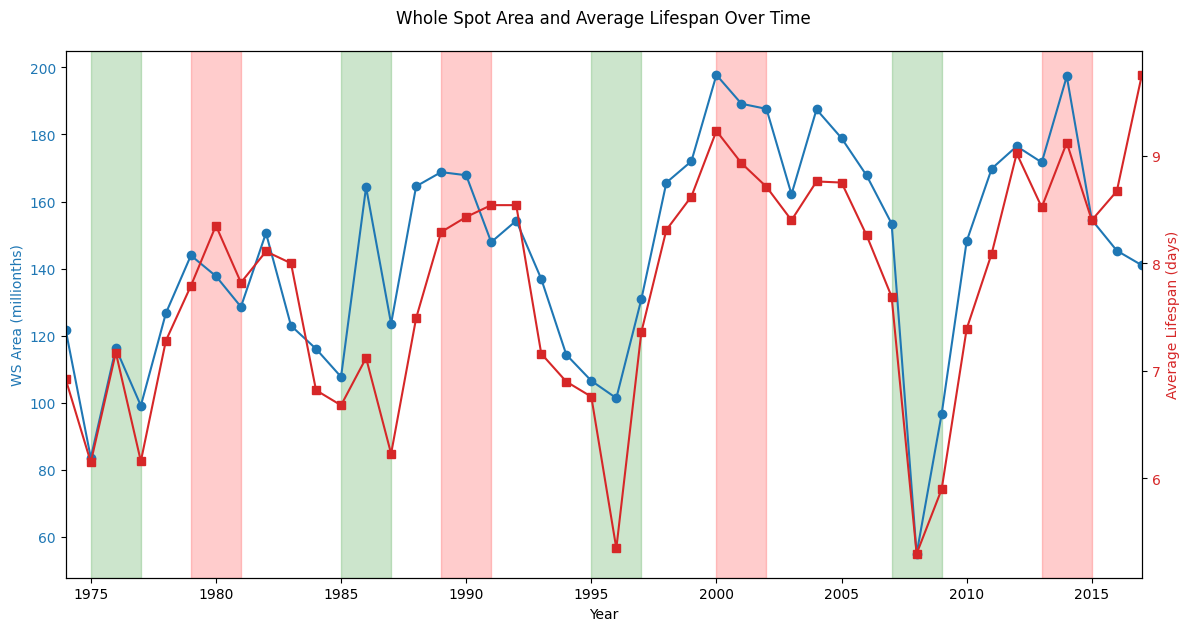

In [57]:
fig, ax1 = plt.subplots(figsize=(12, 6))
solar_maximum_ranges = [(int(max_year) - 1, int(max_year) + 1) for max_year in solar_maximum_years]
solar_minimum_ranges = [(int(min_year) - 1, int(min_year) + 1) for min_year in solar_minimum_years]

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('WS Area (millionths)', color=color)
ax1.plot(years, ws_area_per_year, color=color, marker='o', label='WS Area')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Average Lifespan (days)', color=color)
ax2.plot(years, avg_lifespan_year, color=color, marker='s', label='Average Lifespan')
ax2.tick_params(axis='y', labelcolor=color)

for start, end in solar_maximum_ranges:
    ax1.axvspan(start, end, color='red', alpha=0.2, label='Solar Maximum Range' if start == int(solar_maximum_years[0]) - 1 else '')

# Highlight solar minimum ranges (in light green)
for start, end in solar_minimum_ranges:
    ax1.axvspan(start, end, color='green', alpha=0.2, label='Solar Minimum Range' if start == int(solar_minimum_years[0]) - 1 else '')


fig.tight_layout()
plt.title("Whole Spot Area and Average Lifespan Over Time", pad=20)
plt.xlim(left=list_of_years[0], right=list_of_years[-1])  # or something like plt.xlim(1979.5, None)
#save the graph in images directory
# Construct the full file path
# Save the figure to the specified directory
plt.savefig('Whole spot area and avg lifespan')
plt.show()

Lets check correlation between the data using pearsons and spearmans.

In [10]:
from scipy import stats
"""
The Pearson correlation coefficient [1] measures the linear relationship between two datasets. Like other correlation coefficients,
this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship.
Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
"""

"""
The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson
correlation at least as extreme as the one computed from these datasets.
"""

# Pearson Correlation Solar Max
pearson_corr, p_value_pearson = stats.pearsonr(ws_area_per_year, avg_lifespan_year)

"""
The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets.
Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply
an exact monotonic relationship. Positive correlations imply that as x increases, so does y.
Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at
least as extreme as the one computed from these datasets. Although calculation of the p-value does not make strong assumptions
about the distributions underlying the samples, it is only accurate for very large samples (>500 observations).
For smaller sample sizes, consider a permutation test (see Examples section below).

p = some value means the chance that this correlation is die to random variation
"""

# Spearman Correlation
spearman_corr, p_value_spearman = stats.spearmanr(ws_area_per_year, avg_lifespan_year)

print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {p_value_pearson:.3f}")

print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {p_value_spearman:.3f}")


Pearson Correlation: 0.851, p-value: 0.000
Spearman Correlation: 0.843, p-value: 0.000
